In [1]:
import torch
from torchvision import datasets, models, transforms
from torch import nn, optim
from os import listdir
from os.path import join, isfile
from PIL import Image
import pandas as pd

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the images
])

# Load the dataset
data_dir = "data\PNG"
class_names = ['normal', 'cancer']  # Replace with your class names

# Create a dictionary to map class names to integers
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

# Create a custom dataset class to load the images from the directories
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self,csv_file,transform):
        df = pd.read_csv(csv_file)
        df = df[['pathology', 'image file path']]
        pathology = df['pathology'].values
        self.labels = [1 if label == 'MALIGNANT' else 0 for label in pathology]
        self.transform = transform

        new = df['image file path'].str.split('/', n=3, expand=False)
        new = new.apply(lambda x: x[2])
        df['image file path'] = "data/jpeg/"+new[2]
        folder_paths = df['image file path'].values
        self.file_paths = [join(folder_path, listdir(folder_path)[0]) for folder_path in folder_paths]
    
    def __getitem__(self, index):
        label = self.labels[index]
        image = Image.open(self.file_paths[index]).convert('RGB')
        image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

# set up a basic transform set that just converts from numpy/opencv format to torch, and then resizes appropriatly
plain_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        ])

# create the dataset object given your csv and transform we just set up
dataset = CancerDataset("data\csv\calc_case_description_test_set.csv",plain_transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])



In [ ]:
from torch.utils.data import WeightedRandomSampler

# get target labes of all samples
targets = [sample[1] for sample in train_dataset]
# count num of samples in each class
class_counts=[targets.count(i) for i in range(len(class_names))]
num_samples = sum(class_counts)
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights_train = [class_weights[targets[i]] for i in range(int(num_samples))]

# Create data loaders
sampler_train = WeightedRandomSampler(torch.DoubleTensor(weights_train), int(num_samples))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, sampler = sampler_train)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load a pre-trained model (ResNet-18)
model = models.resnet18(pretrained=True)

# Freeze the model's parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer of the model with a new classifier
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
# Train the model
num_epochs = 10
running_loss_history = []
val_loss_history = []
true_positives = {class_name: 0 for class_name in class_names}
false_positives = {class_name: 0 for class_name in class_names}
false_negatives = {class_name: 0 for class_name in class_names}

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validate the model
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_accuracy = correct / total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    model.train()
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update TP, FP, and FN for each class
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(labels)):
        true_label = class_names[labels[i]]
        predicted_label = class_names[predicted[i]]

        if true_label == predicted_label:
            true_positives[true_label] += 1
        elif predicted_label != 'normal':
            false_positives[predicted_label] += 1
        else:
            false_negatives[true_label] += 1

# Save the trained model
torch.save(model.state_dict(), "classifier_model.pth")

Epoch 1/10, Loss: 0.7149
Validation Loss: 0.7510, Accuracy: 0.3636
Epoch 2/10, Loss: 0.7371
Validation Loss: 1.9280, Accuracy: 0.3636
Epoch 3/10, Loss: 0.7381
Validation Loss: 1.2883, Accuracy: 0.3636
Epoch 4/10, Loss: 0.6962
Validation Loss: 2.0355, Accuracy: 0.3636
Epoch 5/10, Loss: 0.7077
Validation Loss: 1.5113, Accuracy: 0.3636
Epoch 6/10, Loss: 0.6816
Validation Loss: 1.6104, Accuracy: 0.3636
Epoch 7/10, Loss: 0.7097
Validation Loss: 0.9982, Accuracy: 0.3636
Epoch 8/10, Loss: 0.7090
Validation Loss: 0.6971, Accuracy: 0.3636
Epoch 9/10, Loss: 0.7102
Validation Loss: 0.9069, Accuracy: 0.3636
Epoch 10/10, Loss: 0.6992
Validation Loss: 0.8061, Accuracy: 0.3636


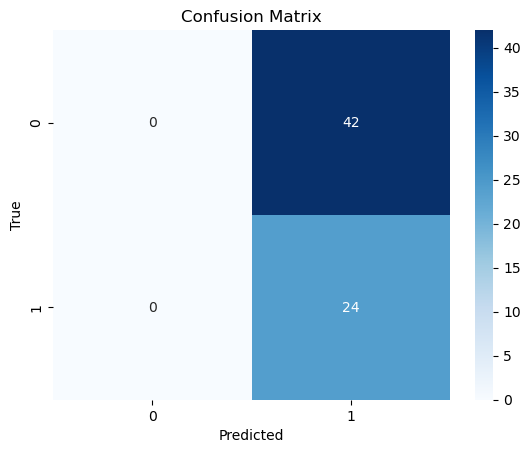

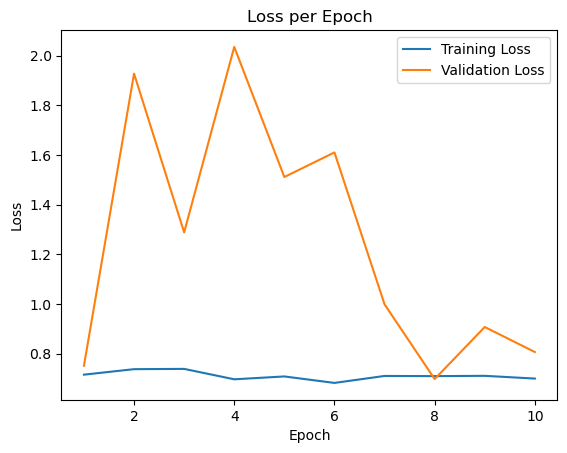

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set the device for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Create a list to store the predicted labels and true labels
predicted_labels = []
true_labels = []

# Iterate over the validation dataset and make predictions
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Graph the loss per epoch
loss_values = [epoch_loss for epoch_loss in running_loss_history]
val_loss_values = [val_loss for val_loss in val_loss_history]

epochs = range(1, num_epochs + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

In [ ]:
# Calculate precision and recall for each class
precision = {class_name: true_positives[class_name] / (true_positives[class_name] + false_positives[class_name]) for class_name in class_names}
recall = {class_name: true_positives[class_name] / (true_positives[class_name] + false_negatives[class_name]) for class_name in class_names}

def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

f1_score = calculate_f1_score(precision, recall)
print("F1 Score:", f1_score)